<a href="https://colab.research.google.com/github/abhishtagatya/paintgan-model-comparison/blob/main/deception_score_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip drive/MyDrive/Dataset/wikiart.zip

Streaming output truncated to the last 5000 lines.
  inflating: wikiart/Romanticism/ivan-aivazovsky_farewell-1895.jpg  
  inflating: wikiart/Romanticism/john-atkinson-grimshaw_forge-valley-scarborough.jpg  
  inflating: wikiart/Romanticism/thomas-cole_the-dream-of-the-architect-1840.jpg  
  inflating: wikiart/Romanticism/dante-gabriel-rossetti_image-of-artist-and-his-exotic-pet-1871.jpg  
  inflating: wikiart/Romanticism/alexey-bogolyubov_smolny-as-seen-from-bolshaya-okhta-1852.jpg  
  inflating: wikiart/Romanticism/adolphe-joseph-thomas-monticelli_the-adoration-of-the-magi.jpg  
  inflating: wikiart/Romanticism/adolphe-joseph-thomas-monticelli_the-offering.jpg  
  inflating: wikiart/Romanticism/vasily-tropinin_portrait-of-d-p-voyeikov-with-his-daughter-and-the-governess-miss-sorock-1842.jpg  
  inflating: wikiart/Romanticism/george-stubbs_spanish-pointer.jpg  
  inflating: wikiart/Romanticism/konstantin-makovsky_russian-beauty.jpg  
  inflating: wikiart/Romanticism/taras-shevchenko_gi

## Data Restructuring

In [3]:
import os
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator

WIKIART_BASEPATH = 'wikiart'
wikiart_folder = os.listdir(WIKIART_BASEPATH)

In [4]:
from struct import unpack

class JPEG:
  
  def __init__(self, image_file):
    self.marker_mapping = {
        0xffd8: "Start of Image",
        0xffe0: "Application Default Header",
        0xffdb: "Quantization Table",
        0xffc0: "Start of Frame",
        0xffc4: "Define Huffman Table",
        0xffda: "Start of Scan",
        0xffd9: "End of Image"
    }
    
    with open(image_file, 'rb') as f:
      self.img_data = f.read()
    
  def decode(self):
    data = self.img_data
    while(True):
      marker, = unpack(">H", data[0:2])
      if marker == 0xffd8:
        data = data[2:]
      elif marker == 0xffd9:
        return
      elif marker == 0xffda:
        data = data[-2:]
      else:
        lenchunk, = unpack(">H", data[2:4])
        data = data[2+lenchunk:]            
        if len(data) == 0:
          break 

In [5]:
def gen_label_dataset():
  dataset = []
  for folder in tqdm(wikiart_folder):
    path = os.path.join(WIKIART_BASEPATH, folder)
    for file in os.listdir(path):
      artist_label = file.split('/')[-1].split('_')[0]
      file_path = os.path.join(path, file)
      image = JPEG(file_path) 
      try:
        image.decode()
        dataset.append((
          file_path,
          folder,
          artist_label
        ))
      except:
        pass
  return dataset

dataset = gen_label_dataset()

100%|██████████| 27/27 [04:09<00:00,  9.24s/it]


In [6]:
painting_df = pd.DataFrame(dataset, columns=['Path', 'Style', 'Artist'])

In [7]:
len(painting_df[painting_df.groupby(
      'Artist'
  )['Artist'].transform('size') > 200]['Artist'].value_counts())

82

In [8]:
import math
import numpy as np
import random

MAX_CLASSES=82

def resample_artist_by_style(max_classes=MAX_CLASSES, min_entry=200, per_artist_max=350):
  artist_vc = painting_df[painting_df.groupby(
      'Artist'
  )['Artist'].transform('size') > min_entry]['Artist'].value_counts()[:max_classes].index

  master_df = pd.DataFrame(columns=['Path', 'Style', 'Artist'])

  for artist in artist_vc:
    artist_painting = painting_df[painting_df['Artist'] == artist]
    artist_painting_total = len(artist_painting)

    artist_style_era = artist_painting['Style'].value_counts().index
    artist_styles_era_total = len(artist_style_era)

    for style_era in artist_style_era:
      artist_this_era = artist_painting[artist_painting['Style'] == style_era]
      artist_total_this_era = len(artist_this_era)

      percentage_of_total_works = round(artist_total_this_era / artist_painting_total, 2)
      total_to_sample = math.floor(percentage_of_total_works * per_artist_max)

      print(artist, artist_painting_total, percentage_of_total_works, artist_total_this_era, total_to_sample)
      if total_to_sample >= artist_total_this_era: 
        # Special cases where numbers are to close and decimal points does not reach
        selected_works = artist_this_era.sample(n=artist_total_this_era)
      else:
        selected_works = artist_this_era.sample(n=total_to_sample)
        
      master_df = master_df.append(selected_works)
  
  return master_df

In [9]:
resample_df = resample_artist_by_style()

vincent-van-gogh 1864 0.53 992 185
vincent-van-gogh 1864 0.47 872 164
nicholas-roerich 1860 0.65 1200 227
nicholas-roerich 1860 0.29 545 101
nicholas-roerich 1860 0.06 115 21
pierre-auguste-renoir 1394 0.98 1370 343
pierre-auguste-renoir 1394 0.02 24 7
claude-monet 1334 0.99 1320 346
claude-monet 1334 0.01 14 3
pyotr-konchalovsky 989 0.39 382 136
pyotr-konchalovsky 989 0.33 327 115
pyotr-konchalovsky 989 0.1 99 35
pyotr-konchalovsky 989 0.09 88 31
pyotr-konchalovsky 989 0.08 78 28
pyotr-konchalovsky 989 0.01 10 3
pyotr-konchalovsky 989 0.01 5 3
camille-pissarro 887 0.89 790 311
camille-pissarro 887 0.06 56 21
camille-pissarro 887 0.05 41 17
albrecht-durer 828 1.0 828 350
pablo-picasso 800 0.26 211 91
pablo-picasso 800 0.25 203 87
pablo-picasso 800 0.14 115 49
pablo-picasso 800 0.1 76 35
pablo-picasso 800 0.07 53 24
pablo-picasso 800 0.06 50 21
pablo-picasso 800 0.04 29 14
pablo-picasso 800 0.03 24 10
pablo-picasso 800 0.03 21 10
pablo-picasso 800 0.02 16 7
pablo-picasso 800 0.0 2 0
joh

In [ ]:
resample_df[resample_df['Artist'] == 'vincent-van-gogh']['Artist'].value_counts()

vincent-van-gogh    349
Name: Artist, dtype: int64

In [ ]:
def random_crop(img, random_crop_size=(224, 224)):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = (random_crop_size)
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]

In [142]:
augs_gen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    rotation_range=40,
    horizontal_flip=True,
    validation_split=0.2
)

In [ ]:
train_generator = augs_gen.flow_from_dataframe(
    resample_df,
    x_col='Path',
    y_col='Artist',
    target_size=(224, 224),
    color_mode='rgb',
    shuffle=True,
    batch_size=32,
    class_mode='categorical',
    validate_filenames=True,
    interpolation='nearest',
)

test_generator = augs_gen.flow_from_dataframe(
    resample_df,
    x_col='Path',
    y_col='Artist',
    target_size=(224, 224),
    color_mode='rgb',
    shuffle=True,
    batch_size=32,
    class_mode='categorical',
    validate_filenames=True,
    interpolation='nearest',
    subset='validation'
)

Found 24219 validated image filenames belonging to 82 classes.
Found 4843 validated image filenames belonging to 82 classes.


In [ ]:
x,y = test_generator.next()

In [139]:
# Implement VGG16 Classifier from Scratch

from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.layers import MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import Model, Sequential
from tensorflow.keras.regularizers import l2

def build_vgg16(num_classes=MAX_CLASSES):
  vgg16c = tf.keras.Sequential()
  vgg16c.add(Input(shape=(224, 224, 3)))

  # First Block
  vgg16c.add(Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
  vgg16c.add(BatchNormalization())
  vgg16c.add(Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
  vgg16c.add(BatchNormalization())
  vgg16c.add(MaxPool2D(pool_size=2, strides=2, padding="same"))

  # Second Block
  vgg16c.add(Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
  vgg16c.add(BatchNormalization())
  vgg16c.add(Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
  vgg16c.add(BatchNormalization())
  vgg16c.add(MaxPool2D(pool_size=2, strides=2, padding="same"))

  # Third Block
  vgg16c.add(Conv2D(filters=256, kernel_size=3, padding="same", activation="relu", kernel_regularizer=l2(0.01)))
  vgg16c.add(BatchNormalization())
  vgg16c.add(Conv2D(filters=256, kernel_size=3, padding="same", activation="relu", kernel_regularizer=l2(0.01)))
  vgg16c.add(BatchNormalization())
  vgg16c.add(Conv2D(filters=256, kernel_size=3, padding="same", activation="relu", kernel_regularizer=l2(0.01)))
  vgg16c.add(BatchNormalization())
  vgg16c.add(MaxPool2D(pool_size=2, strides=2, padding="same"))

  # Fourth Block
  vgg16c.add(Conv2D(filters=512, kernel_size=3, padding="same", activation="relu", kernel_regularizer=l2(0.01)))
  vgg16c.add(BatchNormalization())
  vgg16c.add(Conv2D(filters=512, kernel_size=3, padding="same", activation="relu", kernel_regularizer=l2(0.01)))
  vgg16c.add(BatchNormalization())
  vgg16c.add(Conv2D(filters=512, kernel_size=3, padding="same", activation="relu", kernel_regularizer=l2(0.01)))
  vgg16c.add(BatchNormalization())
  vgg16c.add(MaxPool2D(pool_size=2, strides=2, padding="same"))

  # Fifth Block
  vgg16c.add(Conv2D(filters=512, kernel_size=3, padding="same", activation="relu", kernel_regularizer=l2(0.01)))
  vgg16c.add(BatchNormalization())
  vgg16c.add(Conv2D(filters=512, kernel_size=3, padding="same", activation="relu", kernel_regularizer=l2(0.01)))
  vgg16c.add(BatchNormalization())
  vgg16c.add(Conv2D(filters=512, kernel_size=3, padding="same", activation="relu", kernel_regularizer=l2(0.01)))
  vgg16c.add(BatchNormalization())
  vgg16c.add(MaxPool2D(pool_size=2, strides=2, padding="same"))

  # Fully Connected
  vgg16c.add(Flatten())
  vgg16c.add(Dense(units=4096, activation="relu"))
  vgg16c.add(Dropout(0.3))
  vgg16c.add(Dense(units=4096, activation="relu"))
  vgg16c.add(Dropout(0.3))
  vgg16c.add(Dense(units=num_classes, activation="softmax"))
  
  return vgg16c

vgg16c = build_vgg16()

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_accuracy', save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='auto')
csv_logger = keras.callbacks.CSVLogger(f'vgg16_1.csv', append=True, separator=';')

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

vgg16c.compile(
    optimizer=optimizer,
    loss=keras.losses.categorical_crossentropy,
    metrics=['accuracy']
)

In [ ]:
history = vgg16c.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,
    batch_size=32,
    callbacks=[
      checkpoint, early, csv_logger
    ]
)

Epoch 1/30
757/757 [==============================] - 895s 1s/step - loss: 39.8716 - accuracy: 0.0728 - val_loss: 38.8555 - val_accuracy: 0.1784
Epoch 2/30
757/757 [==============================] - 873s 1s/step - loss: 38.6810 - accuracy: 0.1456 - val_loss: 37.9587 - val_accuracy: 0.1916
Epoch 3/30
757/757 [==============================] - 879s 1s/step - loss: 37.7228 - accuracy: 0.1900 - val_loss: 37.0198 - val_accuracy: 0.2216
Epoch 4/30
757/757 [==============================] - 885s 1s/step - loss: 36.7307 - accuracy: 0.2247 - val_loss: 35.9984 - val_accuracy: 0.2709
Epoch 5/30
757/757 [==============================] - 881s 1s/step - loss: 35.7248 - accuracy: 0.2502 - val_loss: 34.9301 - val_accuracy: 0.2938
Epoch 6/30
757/757 [==============================] - 890s 1s/step - loss: 34.6861 - accuracy: 0.2712 - val_loss: 33.8440 - val_accuracy: 0.3114
Epoch 7/30
757/757 [==============================] - 887s 1s/step - loss: 33.5850 - accuracy: 0.2969 - val_loss: 32.8540 - val_ac

In [ ]:
!mv vgg16_1.h5 drive/MyDrive/Dataset/vgg16_3.h5

In [118]:
style_images = {
    'vincent-van-gogh': resample_df[(resample_df['Artist'] == 'vincent-van-gogh') & (resample_df['Style'] == 'Post_Impressionism')].sample(n=1)['Path'].item(),
    'rembrandt': resample_df[(resample_df['Artist'] == 'rembrandt') & (resample_df['Style'] == 'Baroque')].sample(n=1)['Path'].item(),
    'pablo-picasso': resample_df[(resample_df['Artist'] == 'pablo-picasso') & (resample_df['Style'] == 'Cubism')].sample(n=1)['Path'].item(),
    'claude-monet': resample_df[(resample_df['Artist'] == 'claude-monet') & (resample_df['Style'] == 'Impressionism')].sample(n=1)['Path'].item(),
    'salvador-dali': resample_df[(resample_df['Artist'] == 'salvador-dali') & (resample_df['Style'] == 'Expressionism')].sample(n=1)['Path'].item(),
    'leonardo-da-vinci': resample_df[(resample_df['Artist'] == 'leonardo-da-vinci') & (resample_df['Style'] == 'High_Renaissance')].sample(n=1)['Path'].item(),
    'nicholas-roerich': resample_df[(resample_df['Artist'] == 'nicholas-roerich') & (resample_df['Style'] == 'Symbolism')].sample(n=1)['Path'].item(),
    'andy-warhol': resample_df[(resample_df['Artist'] == 'andy-warhol') & (resample_df['Style'] == 'Pop_Art')].sample(n=1)['Path'].item(),
}

In [119]:
style_images

{'andy-warhol': 'wikiart/Pop_Art/andy-warhol_tatum-o-neal-1987.jpg',
 'claude-monet': 'wikiart/Impressionism/claude-monet_grainstacks-at-giverny-sunset.jpg',
 'leonardo-da-vinci': 'wikiart/High_Renaissance/leonardo-da-vinci_rearing-horse.jpg',
 'nicholas-roerich': 'wikiart/Symbolism/nicholas-roerich_the-straight-path-1912.jpg',
 'pablo-picasso': 'wikiart/Cubism/pablo-picasso_drawing-woman-surrounded-by-her-children-1950.jpg',
 'rembrandt': 'wikiart/Baroque/rembrandt_lighting-study-of-an-elderly-woman-in-a-white-cap.jpg',
 'salvador-dali': 'wikiart/Expressionism/salvador-dali_portrait-of-my-father-1.jpg',
 'vincent-van-gogh': 'wikiart/Post_Impressionism/vincent-van-gogh_a-steamer-with-several-people-1890(1).jpg'}

In [122]:
style_images_select = {
    'andy-warhol': 'wikiart/Pop_Art/andy-warhol_queen-margrethe-ii-of-denmark.jpg',
    'claude-monet': 'wikiart/Impressionism/claude-monet_meadow-at-bezons.jpg',
    'leonardo-da-vinci': 'wikiart/High_Renaissance/leonardo-da-vinci_heads-of-judas-and-peter.jpg',
    'nicholas-roerich': 'wikiart/Symbolism/nicholas-roerich_order-of-rigden-jyepo-1947.jpg',
    'pablo-picasso': 'wikiart/Cubism/pablo-picasso_flowers-on-the-table-1907.jpg',
    'rembrandt': 'wikiart/Baroque/rembrandt_portrait-of-an-old-man-in-red-1654-1.jpg',
    'salvador-dali': 'wikiart/Expressionism/salvador-dali_two-adolescents.jpg',
    'vincent-van-gogh': 'wikiart/Post_Impressionism/vincent-van-gogh_the-gully-peiroulets-1889.jpg'
}

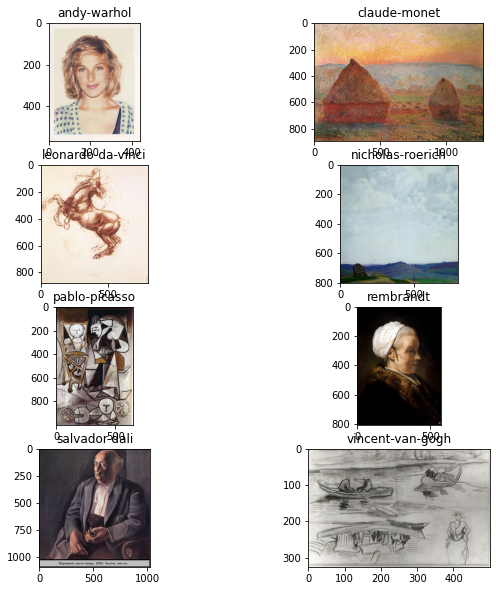

In [123]:
fig, axs = plt.subplots(4, 2, figsize=(10, 10))

x, y = 0, 0

for artist in style_images_select:
  if x + 1 > 2:
    y += 1
    x = 0

  axs[y, x].imshow(plt.imread(style_images[artist]))
  axs[y, x].set_title(artist)
  x += 1

In [124]:
# Download Eval Datasets
# MS-COCO Val

!wget -c http://images.cocodataset.org/zips/val2017.zip

--2022-06-09 17:17:58--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.38.209
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.38.209|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  35.1MB/s    in 23s     

2022-06-09 17:18:21 (33.9 MB/s) - ‘val2017.zip’ saved [815585330/815585330]



In [125]:
!wget -c http://data.csail.mit.edu/places/places365/val_large.tar

--2022-06-09 17:18:39--  http://data.csail.mit.edu/places/places365/val_large.tar
Resolving data.csail.mit.edu (data.csail.mit.edu)... 128.52.129.40
Connecting to data.csail.mit.edu (data.csail.mit.edu)|128.52.129.40|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2270320640 (2.1G) [application/octet-stream]
Saving to: ‘val_large.tar’

val_large.tar       100%[===================>]   2.11G  34.5MB/s    in 64s     

2022-06-09 17:19:44 (34.0 MB/s) - ‘val_large.tar’ saved [2270320640/2270320640]



In [128]:
!unzip val2017.zip -d MSCOCO

Streaming output truncated to the last 5000 lines.
 extracting: MSCOCO/val2017/000000212226.jpg  
 extracting: MSCOCO/val2017/000000231527.jpg  
 extracting: MSCOCO/val2017/000000578922.jpg  
 extracting: MSCOCO/val2017/000000062808.jpg  
 extracting: MSCOCO/val2017/000000119038.jpg  
 extracting: MSCOCO/val2017/000000114871.jpg  
 extracting: MSCOCO/val2017/000000463918.jpg  
 extracting: MSCOCO/val2017/000000365745.jpg  
 extracting: MSCOCO/val2017/000000320425.jpg  
 extracting: MSCOCO/val2017/000000481404.jpg  
 extracting: MSCOCO/val2017/000000314294.jpg  
 extracting: MSCOCO/val2017/000000335328.jpg  
 extracting: MSCOCO/val2017/000000513688.jpg  
 extracting: MSCOCO/val2017/000000158548.jpg  
 extracting: MSCOCO/val2017/000000132116.jpg  
 extracting: MSCOCO/val2017/000000415238.jpg  
 extracting: MSCOCO/val2017/000000321333.jpg  
 extracting: MSCOCO/val2017/000000081738.jpg  
 extracting: MSCOCO/val2017/000000577584.jpg  
 extracting: MSCOCO/val2017/000000346905.jpg  
 extracti

In [131]:
!rm -rrf val_large/

In [134]:
mkdir places365

In [137]:
!tar -xvf val_large.tar -C places365

Streaming output truncated to the last 5000 lines.
val_large/Places365_val_00026825.jpg
val_large/Places365_val_00023309.jpg
val_large/Places365_val_00014340.jpg
val_large/Places365_val_00018327.jpg
val_large/Places365_val_00014895.jpg
val_large/Places365_val_00003619.jpg
val_large/Places365_val_00034650.jpg
val_large/Places365_val_00006147.jpg
val_large/Places365_val_00018480.jpg
val_large/Places365_val_00019915.jpg
val_large/Places365_val_00019567.jpg
val_large/Places365_val_00015500.jpg
val_large/Places365_val_00015972.jpg
val_large/Places365_val_00022549.jpg
val_large/Places365_val_00027217.jpg
val_large/Places365_val_00007707.jpg
val_large/Places365_val_00035010.jpg
val_large/Places365_val_00002059.jpg
val_large/Places365_val_00028365.jpg
val_large/Places365_val_00016867.jpg
val_large/Places365_val_00016415.jpg
val_large/Places365_val_00024302.jpg
val_large/Places365_val_00004612.jpg
val_large/Places365_val_00036105.jpg
val_large/Places365_val_00008675.jpg
val_large/Places365_val_

In [138]:
!wget https://raw.githubusercontent.com/CompVis/adaptive-style-transfer/master/evaluation/evaluation_data/eval_paths_700_val.json

--2022-06-09 17:29:18--  https://raw.githubusercontent.com/CompVis/adaptive-style-transfer/master/evaluation/evaluation_data/eval_paths_700_val.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33901 (33K) [text/plain]
Saving to: ‘eval_paths_700_val.json’

eval_paths_700_val. 100%[===================>]  33.11K  --.-KB/s    in 0.002s  

2022-06-09 17:29:18 (14.9 MB/s) - ‘eval_paths_700_val.json’ saved [33901/33901]



In [226]:
!mv val2017.zip drive/MyDrive/Dataset/MSCOCO.zip

In [227]:
!mv val_large.tar drive/MyDrive/Dataset/places365val.tar

In [140]:
# Evaluate Model Metrics

PRETRAINED_PATH = 'drive/MyDrive/Dataset/vgg16_3.h5'

vgg16pt = keras.models.load_model(PRETRAINED_PATH)

In [143]:
# Testing Pre-Trained Model on 

augs_gen_val = ImageDataGenerator(
    rescale=1./255,
    # zoom_range=0.2,
    # rotation_range=40,
    # horizontal_flip=True,
    validation_split=0.1
)

val_generator = augs_gen_val.flow_from_dataframe(
    resample_df,
    x_col='Path',
    y_col='Artist',
    target_size=(224, 224),
    color_mode='rgb',
    shuffle=True,
    batch_size=32,
    class_mode='categorical',
    validate_filenames=True,
    interpolation='nearest',
    subset='validation'
)

Found 2421 validated image filenames belonging to 82 classes.


In [199]:
val_generator

In [158]:
vgg16pt.evaluate(val_generator)

76/76 [==============================] - 48s 621ms/step - loss: 15.3295 - accuracy: 0.3713


[15.329540252685547, 0.37133416533470154]

In [164]:
val_df = resample_df.query(f'Artist=={list(style_images.keys())}')

In [203]:
val_generator = augs_gen_val.flow_from_dataframe(
    val_df,
    x_col='Path',
    y_col='Artist',
    target_size=(224, 224),
    color_mode='rgb',
    shuffle=False,
    batch_size=32,
    classes=list(resample_df['Artist'].unique()),
    class_mode='categorical',
    validate_filenames=True,
    interpolation='nearest',
)

Found 2501 validated image filenames belonging to 82 classes.


In [204]:
list(resample_df['Artist'].unique())

['vincent-van-gogh',
 'nicholas-roerich',
 'pierre-auguste-renoir',
 'claude-monet',
 'pyotr-konchalovsky',
 'camille-pissarro',
 'albrecht-durer',
 'pablo-picasso',
 'john-singer-sargent',
 'rembrandt',
 'marc-chagall',
 'gustave-dore',
 'boris-kustodiev',
 'edgar-degas',
 'salvador-dali',
 'martiros-saryan',
 'paul-cezanne',
 'ivan-aivazovsky',
 'eugene-boudin',
 'childe-hassam',
 'ilya-repin',
 'ivan-shishkin',
 'raphael-kirchner',
 'henri-matisse',
 'camille-corot',
 'odilon-redon',
 'alfred-sisley',
 'isaac-levitan',
 'james-tissot',
 'paul-gauguin',
 'henri-de-toulouse-lautrec',
 'ernst-ludwig-kirchner',
 'maurice-prendergast',
 'peter-paul-rubens',
 'francisco-goya',
 'william-merritt-chase',
 'konstantin-makovsky',
 'zinaida-serebriakova',
 'joaquã\xadn-sorolla',
 'amedeo-modigliani',
 'sam-francis',
 'konstantin-korovin',
 'thomas-eakins',
 'david-burliuk',
 'mary-cassatt',
 'henri-fantin-latour',
 'georges-braque',
 'vasily-surikov',
 'egon-schiele',
 'gustave-courbet',
 'gus

In [205]:
list(style_images.keys())

['vincent-van-gogh',
 'rembrandt',
 'pablo-picasso',
 'claude-monet',
 'salvador-dali',
 'leonardo-da-vinci',
 'nicholas-roerich',
 'andy-warhol']

In [206]:
y_pred = vgg16pt.predict(val_generator)

In [207]:
from tensorflow.keras.utils import to_categorical

y_pred_c = to_categorical(np.argmax(y_pred, axis=1), MAX_CLASSES)

In [216]:
y_pred_s = np.array([np.where(r==1)[0][0] for r in y_pred_c])

In [217]:
y_pred_s

array([58, 67, 78, ..., 78, 50, 60])

In [208]:
)y_pred_c

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [209]:
y_true = to_categorical(val_generator.classes, MAX_CLASSES)

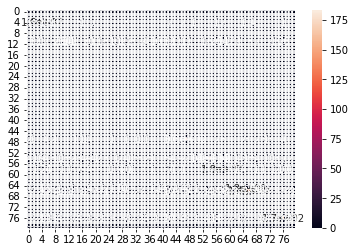

In [223]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

df_cm = pd.DataFrame(confusion_matrix(val_generator.classes, y_pred_s))
sns.heatmap(df_cm, annot=True)

In [ ]:
# Cross Examine Deception Rate

In [228]:
# Readjust Eval Path

import json

with open('eval_paths_700_val.json', 'r') as eval_file:
  eval_json = json.load(eval_file)

In [230]:
len(eval_json) # Make it smaller?

700

In [232]:
eval_json_min = random.choices(eval_json, k=70)

In [237]:
eval_json_min_s = sorted([path.replace('validation', 'val_large') for path in eval_json_min])

In [239]:
with open('eval_paths_70_val.json', 'w') as eval_file:
  json.dump(eval_json_min_s, eval_file)

In [240]:
!mv eval_paths_70_val.json drive/MyDrive/Dataset/eval_paths_70_val.json